Contents

1. The Black Friday Kaggle Challenge: understanding the competition and reading in data
2. Define functions for this machine learning exerise
3. Preprocess train data using the defined functions
4. Model building, hyperparameter tuning, and some exploratory data analysis (EDA)
5. Test out your model

# 1. The Black Friday Kaggle Challenge: understanding the competition and reading in data

'''Please visit the Kaggle website for this competition to learn more.
https://www.kaggle.com/sdolezel/black-friday/. 

In [1]:
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Check the path to the directory where you are currently in
%pwd
mypath = %pwd

In [3]:
'''Define a variable that points to this. This will let you avoid typing
the long path everytime you need to use it'''

my_path = '%s' %mypath

# II. Reading data into the notebook

In [4]:
'''Read in training data'''
my_df = pd.read_csv(f'{my_path}/black-friday/train.csv')
print(my_df.shape)
my_df.head(2)

(550068, 12)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200


In [5]:
import pandas_profiling
pandas_profiling.ProfileReport(my_df)

In [6]:
my_df.tail(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
550066,1006038,P00375436,F,55+,1,C,2,0,20,NaN,NaN,365
550067,1006039,P00371644,F,46-50,0,B,4+,1,20,NaN,NaN,490


In [7]:
my_df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [8]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [9]:
my_df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [10]:
my_df["Purchase"].describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

# 2. Define functions for this machine learning exerise

In [11]:
'''Define functions to preprocess data - split dates, categorize, impute'''

def split_dates(df,date_column):
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
              "month": df[date_column].dt.month,
              "day": df[date_column].dt.day,
              "dayofyear": df[date_column].dt.dayofyear,
              "week": df[date_column].dt.week,
              "weekofyear": df[date_column].dt.weekofyear,
              "dayofweek": df[date_column].dt.dayofweek,
              "weekday": df[date_column].dt.weekday,
              "quarter": df[date_column].dt.quarter,
             })
    df = df.drop(date_column,axis = 1)
    df = pd.concat([df,date_df],axis = 1)
    return df

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [12]:
'''Define functions to split data, measure accuracy, and r-squared'''

def split_df(df,num):
    return df[ :num].copy(),df[num: ].copy()

def my_rmse(y1,y2):
    return np.sqrt(((y1-y2)**2).mean())

def rsq_n_rmse(my_model,x_train,y_train,x_val,y_val):
    result = [my_model.score(x_train,y_train),my_model.score(x_val,y_val),
             my_rmse(my_model.predict(x_train),y_train),my_rmse(my_model.predict(x_val),y_val)]
    return "train rsq,val rsq,train rmse, val rmse", result


# 3. Preprocess train data using the defined functions

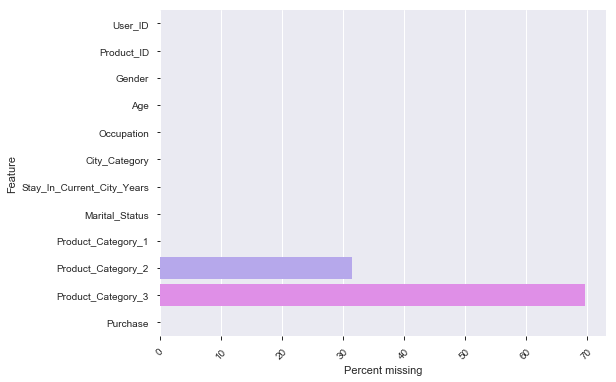

In [13]:
'''First, calculate the percentage of missing values for every column, and 
plot them as a bar chart'''

null_vals = my_df.isnull().sum()/len(my_df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Percent missing",y ="Feature",data = null_vals,orient = "h")

From the above plot, it looks like Product_Category_3  has ~80%missing values. 
It would be meaningless to impute or fill in 80% values, so we drop the column.
We will impute Product_Category_2 (which has ~ 30% missing).These have very little missing values

my_df_1 = my_df.drop("Product_Category_3",axis = 1)
print(my_df_1.shape)
my_df_1.head(2)

In [14]:
my_df_1 = str_to_cat(my_df)
print(my_df_1.shape)
my_df_1.head(3)

(550068, 12)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422


In [15]:
my_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null category
Gender                        550068 non-null category
Age                           550068 non-null category
Occupation                    550068 non-null int64
City_Category                 550068 non-null category
Stay_In_Current_City_Years    550068 non-null category
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: category(5), float64(2), int64(5)
memory usage: 32.7 MB


# Correlations between different variables in a dataframe:


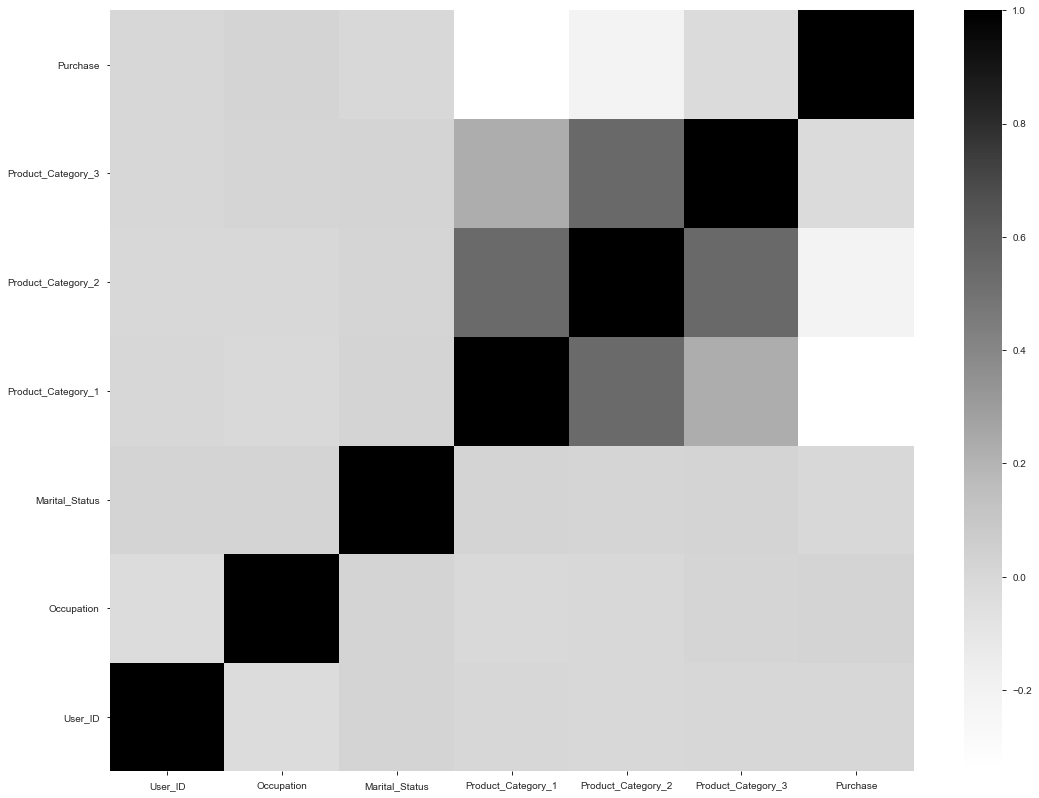

In [16]:
fig = plt.figure(figsize=(18, 14))
corr = my_df_1.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

In [17]:
my_df_2,my_table = mydf_preprocessor(my_df_1,null_table = None)
print(my_df_2.shape)
my_df_2.head(3)

(550068, 14)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Product_Category_2_na,Product_Category_3_na
0,1000001,673,1,1,10,1,3,0,3,9.0,14.0,8370,True,True
1,1000001,2377,1,1,10,1,3,0,1,6.0,14.0,15200,False,False
2,1000001,853,1,1,10,1,3,0,12,9.0,14.0,1422,True,True


In [18]:
my_table

{'Product_Category_2': 9.0, 'Product_Category_3': 14.0}

In [19]:
my_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 14 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null int16
Gender                        550068 non-null int8
Age                           550068 non-null int8
Occupation                    550068 non-null int64
City_Category                 550068 non-null int8
Stay_In_Current_City_Years    550068 non-null int8
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            550068 non-null float64
Product_Category_3            550068 non-null float64
Purchase                      550068 non-null int64
Product_Category_2_na         550068 non-null bool
Product_Category_3_na         550068 non-null bool
dtypes: bool(2), float64(2), int16(1), int64(5), int8(4)
memory usage: 33.6 MB


In [20]:
my_df_final = my_df_2
my_df_final.shape

(550068, 14)

In [21]:
mydf_train_draft1=my_df_final.drop(columns =['Product_Category_2_na','Product_Category_3_na'])

In [23]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = mydf_train_draft1["Purchase"]
X = mydf_train_draft1.drop(["Purchase"],axis = 1)

print(X.shape,Y.shape)

(550068, 11) (550068,)


In [24]:
mydf_train_draft1.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [25]:
'''Note that the different continuous variable columns of this dataframe 
have numbers in different ranges. For example, the Fare and age columns. 
For some machine learning algorithms like Decision Trees and 
their ensembles (Random Forests, for example) the above X and Y
can be directly used as input. However, for a lot of other ML algorithms 
like K nearest neighbors (KNN), we need to scale the continuous variables 
so that their values are mapped to a number between 0 and 1. 
Let's split this dataframe into continuous variable 
columns and those with categorical variables. We will leave 
the categorical variables untouched because their 
values are treated as different levels and its kind of meaningless to
scale them'''

X_con = X[['User_ID', 'Product_ID', 'Gender', 'Age','City_Category','Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Occupation',
       'Stay_In_Current_City_Years', 'Marital_Status']]
X_cat = X.drop(X_con,axis = 1)
print(X_cat.shape,X_con.shape)


(550068, 0) (550068, 11)


In [26]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''

scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ['User_ID', 'Product_ID', 'Gender', 'Age','City_Category','Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Occupation',
       'Stay_In_Current_City_Years', 'Marital_Status']
print(X_con_sc.shape)
X_con_sc.head(2)

(550068, 11)


,User_ID,Product_ID,Gender,Age,City_Category,Product_Category_1,Product_Category_2,Product_Category_3,Occupation,Stay_In_Current_City_Years,Marital_Status
0,-1.752639,-1.022993,-1.746513,-1.844248,-1.371516,-0.610809,-0.136401,0.171658,0.294864,0.109801,-0.833018
1,-1.752639,0.660469,-1.746513,-1.844248,-1.371516,-1.118912,-0.846289,0.171658,0.294864,0.109801,-0.833018


In [27]:
'''Store this scaler variable or its mean and SD, by pickling or something;
we need to use the same mean and SD scaler later while pre-processing 
the test set. Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(550068, 11)


,User_ID,Product_ID,Gender,Age,City_Category,Product_Category_1,Product_Category_2,Product_Category_3,Occupation,Stay_In_Current_City_Years,Marital_Status
0,-1.752639,-1.022993,-1.746513,-1.844248,-1.371516,-0.610809,-0.136401,0.171658,0.294864,0.109801,-0.833018
1,-1.752639,0.660469,-1.746513,-1.844248,-1.371516,-1.118912,-0.846289,0.171658,0.294864,0.109801,-0.833018


In [28]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''


#15% of 550069 = 82510 rows  
# 550069 - 82510 rows =467,559 which is approx 468,000

X_train,X_valid = split_df(X_full,468000)
Y_train,Y_valid = split_df(Y,468000)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(468000, 11) (82068, 11) (468000,) (82068,)


# Build and compile a deep learning model

In [32]:
# Build the deep neural network

model = Sequential()
#Input layer
model.add(Dense(15, input_dim=11, init='normal', activation='relu'))
#Hidden layer
model.add(Dense(10, init='normal', activation='relu'))
model.add(Dense(6, init='normal', activation='relu'))
model.add(Dense(4, init='normal', activation='relu'))
#Output layer
model.add(Dense(1, init='normal'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`
  # This is added back by 

In [33]:

# Compile the DNN
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [34]:
# Fit the DNN with your train data

model_output= model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), nb_epoch=100, batch_size=1000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until
W0807 16:58:21.878837 14232 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0807 16:58:21.972254 14232 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 468000 samples, validate on 82068 samples
Epoch 1/100
468000/468000 [==============================] - 1s 3us/step - loss: 9092.8810 - mean_absolute_error: 9092.8810 - val_loss: 7494.3136 - val_mean_absolute_error: 7494.3136
Epoch 2/100
468000/468000 [==============================] - 1s 2us/step - loss: 4527.1982 - mean_absolute_error: 4527.1982 - val_loss: 3752.6944 - val_mean_absolute_error: 3752.6944
Epoch 3/100
468000/468000 [==============================] - 1s 2us/step - loss: 3488.8768 - mean_absolute_error: 3488.8768 - val_loss: 3531.0378 - val_mean_absolute_error: 3531.0378
Epoch 4/100
468000/468000 [==============================] - 1s 2us/step - loss: 3404.7106 - mean_absolute_error: 3404.7106 - val_loss: 3471.0138 - val_mean_absolute_error: 3471.0138
Epoch 5/100
468000/468000 [==============================] - 1s 2us/step - loss: 3358.2203 - mean_absolute_error: 3358.2203 - val_loss: 3467.9858 - val_mean_absolute_error: 3467.9858
Epoch 6/100
468000/468000 [=======

468000/468000 [==============================] - 1s 2us/step - loss: 2965.4805 - mean_absolute_error: 2965.4805 - val_loss: 3569.7867 - val_mean_absolute_error: 3569.7867
Epoch 90/100
468000/468000 [==============================] - 1s 2us/step - loss: 2965.3142 - mean_absolute_error: 2965.3142 - val_loss: 3561.7799 - val_mean_absolute_error: 3561.7799
Epoch 91/100
468000/468000 [==============================] - 1s 2us/step - loss: 2965.3144 - mean_absolute_error: 2965.3144 - val_loss: 3563.9938 - val_mean_absolute_error: 3563.9938
Epoch 92/100
468000/468000 [==============================] - 1s 2us/step - loss: 2965.2323 - mean_absolute_error: 2965.2323 - val_loss: 3566.9231 - val_mean_absolute_error: 3566.9231
Epoch 93/100
468000/468000 [==============================] - 1s 2us/step - loss: 2965.1981 - mean_absolute_error: 2965.1981 - val_loss: 3571.0603 - val_mean_absolute_error: 3571.0603
Epoch 94/100
468000/468000 [==============================] - 1s 2us/step - loss: 2965.0817 -

'''It looks like param1 and param2 columns contain many null values. In the first
pass, we'll keep them and impute'''

#test out rsq_n_rmse function
rsq_n_rmse(mod_1,x_trn,y_trn,x_val,y_val)

In [35]:
print('Training loss : ' , np.mean(model_output.history["loss"]))
print('Validation loss : ' , np.mean(model_output.history["val_loss"]))

Training loss :  3088.913469488682
Validation loss :  3574.3483306898743


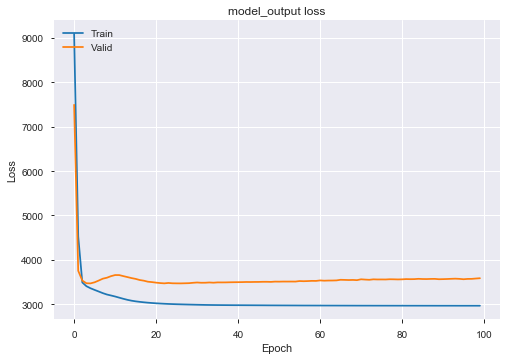

In [36]:
# Plot training & validation loss values
plt.plot(model_output.history['loss'])
plt.plot(model_output.history['val_loss'])
plt.title('model_output loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

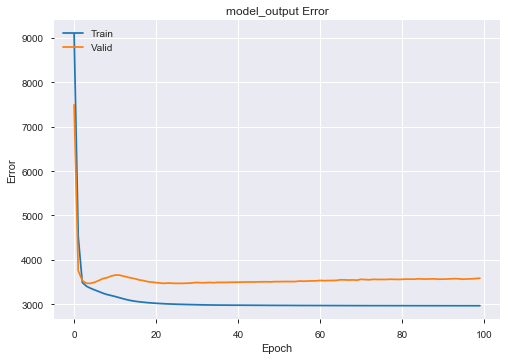

In [37]:
# Plot training & validation loss values
plt.plot(model_output.history['mean_absolute_error'])
plt.plot(model_output.history['val_mean_absolute_error'])
plt.title('model_output Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [38]:
# Evaluate the model
scores = model.evaluate(X_valid, Y_valid)
print ("Value of score: %.2f%%" %(scores[1]*100))

82068/82068 [==============================] - 1s 11us/step
Value of score: 358430.23%


In [39]:
from sklearn.metrics import mean_absolute_error
scores = mean_absolute_error(Y_valid, model.predict(X_valid))
print (scores)

3584.302272171353


# V. Hyperparameter tuning

In [41]:
# Hyperparameter tuning 

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential 
from keras.layers import Dense


def build_regressor (optimizer): 
    model = Sequential()
    #Input layer
    model.add(Dense(15, input_dim=11, init='normal', activation='relu'))
    #Hidden layer
    model.add(Dense(10, init='normal', activation='relu'))
    model.add(Dense(6, init='normal', activation='relu'))
    model.add(Dense(4, init='normal', activation='relu'))
    #Output layer
    model.add(Dense(1, init='normal',))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

NN_model = KerasRegressor(build_fn =build_regressor)

parameters = { 'batch_size':[1000],
               'epochs' :[50],
              'optimizer' :['adam']}


grid_search = GridSearchCV(estimator = NN_model,
                          param_grid = parameters,
                          cv= 10)

grid_result = grid_search.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), nb_epoch=50, batch_size=1000)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
print(means)
stds = grid_result.cv_results_['std_test_score']
print(stds)
params = grid_result.cv_results_['params']
print(params)

print('Training Result :',grid_result.best_estimator_.model.history.history["loss"])

print('Validation Result :',grid_result.best_estimator_.model.history.history["val_loss"])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 1s 3us/step - loss: 9065.3361 - mean_absolute_error: 9065.3361 - val_loss: 7195.6149 - val_mean_absolute_error: 7195.6149
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 4314.7187 - mean_absolute_error: 4314.7187 - val_loss: 3582.5987 - val_mean_absolute_error: 3582.5987
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3462.4579 - mean_absolute_error: 3462.4579 - val_loss: 3410.2820 - val_mean_absolute_error: 3410.2820
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3390.1018 - mean_absolute_error: 3390.1018 - val_loss: 3376.7182 - val_mean_absolute_error: 3376.7182
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3351.5814 - mean_absolute_error: 3351.5814 - val_loss: 3389.7920 - val_mean_absolute_error: 3389.7920
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 1s 3us/step - loss: 9259.9285 - mean_absolute_error: 9259.9285 - val_loss: 8424.2099 - val_mean_absolute_error: 8424.2099
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 5844.0270 - mean_absolute_error: 5844.0270 - val_loss: 3884.5831 - val_mean_absolute_error: 3884.5831
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3526.8123 - mean_absolute_error: 3526.8123 - val_loss: 3609.9452 - val_mean_absolute_error: 3609.9452
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3428.5778 - mean_absolute_error: 3428.5778 - val_loss: 3521.6033 - val_mean_absolute_error: 3521.6033
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3387.1220 - mean_absolute_error: 3387.1220 - val_loss: 3489.1721 - val_mean_absolute_error: 3489.1721
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 1s 3us/step - loss: 9191.4058 - mean_absolute_error: 9191.4058 - val_loss: 8042.4128 - val_mean_absolute_error: 8042.4128
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 5140.4045 - mean_absolute_error: 5140.4045 - val_loss: 3746.4497 - val_mean_absolute_error: 3746.4497
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3498.9293 - mean_absolute_error: 3498.9293 - val_loss: 3506.6413 - val_mean_absolute_error: 3506.6413
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3389.8240 - mean_absolute_error: 3389.8240 - val_loss: 3460.3674 - val_mean_absolute_error: 3460.3674
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3337.2026 - mean_absolute_error: 3337.2026 - val_loss: 3472.6020 - val_mean_absolute_error: 3472.6020
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 1s 3us/step - loss: 9324.2943 - mean_absolute_error: 9324.2943 - val_loss: 8893.3997 - val_mean_absolute_error: 8893.3997
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 9323.8720 - mean_absolute_error: 9323.8720 - val_loss: 8892.9671 - val_mean_absolute_error: 8892.9671
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 9323.4494 - mean_absolute_error: 9323.4494 - val_loss: 8892.5680 - val_mean_absolute_error: 8892.5680
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 9323.0281 - mean_absolute_error: 9323.0281 - val_loss: 8892.1336 - val_mean_absolute_error: 8892.1336
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 9322.6056 - mean_absolute_error: 9322.6056 - val_loss: 8891.7062 - val_mean_absolute_error: 8891.7062
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 1s 3us/step - loss: 8991.4324 - mean_absolute_error: 8991.4324 - val_loss: 6810.8268 - val_mean_absolute_error: 6810.8268
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 4126.9899 - mean_absolute_error: 4126.9899 - val_loss: 3584.9573 - val_mean_absolute_error: 3584.9573
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3434.0698 - mean_absolute_error: 3434.0698 - val_loss: 3472.9860 - val_mean_absolute_error: 3472.9860
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3364.3961 - mean_absolute_error: 3364.3961 - val_loss: 3473.2451 - val_mean_absolute_error: 3473.2451
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3319.5804 - mean_absolute_error: 3319.5804 - val_loss: 3507.6861 - val_mean_absolute_error: 3507.6861
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 1s 3us/step - loss: 9138.4711 - mean_absolute_error: 9138.4711 - val_loss: 7709.3528 - val_mean_absolute_error: 7709.3528
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 4661.3919 - mean_absolute_error: 4661.3919 - val_loss: 3705.1044 - val_mean_absolute_error: 3705.1044
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3467.7166 - mean_absolute_error: 3467.7166 - val_loss: 3515.9672 - val_mean_absolute_error: 3515.9672
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3382.5653 - mean_absolute_error: 3382.5653 - val_loss: 3484.7340 - val_mean_absolute_error: 3484.7340
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3335.6181 - mean_absolute_error: 3335.6181 - val_loss: 3502.6646 - val_mean_absolute_error: 3502.6646
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 1s 3us/step - loss: 9324.7015 - mean_absolute_error: 9324.7015 - val_loss: 8892.4974 - val_mean_absolute_error: 8892.4974
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 9322.4587 - mean_absolute_error: 9322.4587 - val_loss: 8889.3717 - val_mean_absolute_error: 8889.3717
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 9318.5374 - mean_absolute_error: 9318.5374 - val_loss: 8884.6975 - val_mean_absolute_error: 8884.6975
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 9313.1661 - mean_absolute_error: 9313.1661 - val_loss: 8878.6647 - val_mean_absolute_error: 8878.6647
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 9306.5167 - mean_absolute_error: 9306.5167 - val_loss: 8871.4689 - val_mean_absolute_error: 8871.4689
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 2s 4us/step - loss: 9176.9362 - mean_absolute_error: 9176.9362 - val_loss: 7880.7670 - val_mean_absolute_error: 7880.7670
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 4731.7922 - mean_absolute_error: 4731.7922 - val_loss: 3578.1253 - val_mean_absolute_error: 3578.1253
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3435.2683 - mean_absolute_error: 3435.2683 - val_loss: 3443.2117 - val_mean_absolute_error: 3443.2117
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3374.2939 - mean_absolute_error: 3374.2939 - val_loss: 3424.8538 - val_mean_absolute_error: 3424.8538
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3336.9274 - mean_absolute_error: 3336.9274 - val_loss: 3442.4004 - val_mean_absolute_error: 3442.4004
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 2s 4us/step - loss: 9136.3388 - mean_absolute_error: 9136.3388 - val_loss: 7722.1763 - val_mean_absolute_error: 7722.1763
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 4693.8388 - mean_absolute_error: 4693.8388 - val_loss: 3821.2994 - val_mean_absolute_error: 3821.2994
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3536.9712 - mean_absolute_error: 3536.9712 - val_loss: 3539.5540 - val_mean_absolute_error: 3539.5540
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3428.9832 - mean_absolute_error: 3428.9832 - val_loss: 3424.6522 - val_mean_absolute_error: 3424.6522
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3379.0878 - mean_absolute_error: 3379.0878 - val_loss: 3376.7981 - val_mean_absolute_error: 3376.7981
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 82068 samples
Epoch 1/50
421200/421200 [==============================] - 2s 4us/step - loss: 9036.1595 - mean_absolute_error: 9036.1595 - val_loss: 7157.7468 - val_mean_absolute_error: 7157.7468
Epoch 2/50
421200/421200 [==============================] - 1s 2us/step - loss: 4330.3909 - mean_absolute_error: 4330.3909 - val_loss: 3630.1180 - val_mean_absolute_error: 3630.1180
Epoch 3/50
421200/421200 [==============================] - 1s 2us/step - loss: 3435.3623 - mean_absolute_error: 3435.3623 - val_loss: 3468.0387 - val_mean_absolute_error: 3468.0387
Epoch 4/50
421200/421200 [==============================] - 1s 2us/step - loss: 3371.1483 - mean_absolute_error: 3371.1483 - val_loss: 3434.6048 - val_mean_absolute_error: 3434.6048
Epoch 5/50
421200/421200 [==============================] - 1s 2us/step - loss: 3329.9946 - mean_absolute_error: 3329.9946 - val_loss: 3444.9768 - val_mean_absolute_error: 3444.9768
Epoch 6/50
421200/421200 [=============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 468000 samples, validate on 82068 samples
Epoch 1/50
468000/468000 [==============================] - 2s 4us/step - loss: 8288.0615 - mean_absolute_error: 8288.0615 - val_loss: 4372.6866 - val_mean_absolute_error: 4372.6866
Epoch 2/50
468000/468000 [==============================] - 1s 2us/step - loss: 3599.6220 - mean_absolute_error: 3599.6220 - val_loss: 3485.7894 - val_mean_absolute_error: 3485.7894
Epoch 3/50
468000/468000 [==============================] - 1s 2us/step - loss: 3370.1469 - mean_absolute_error: 3370.1469 - val_loss: 3447.5163 - val_mean_absolute_error: 3447.5163
Epoch 4/50
468000/468000 [==============================] - 1s 2us/step - loss: 3314.9229 - mean_absolute_error: 3314.9229 - val_loss: 3490.6855 - val_mean_absolute_error: 3490.6855
Epoch 5/50
468000/468000 [==============================] - 1s 2us/step - loss: 3263.9476 - mean_absolute_error: 3263.9476 - val_loss: 3557.6751 - val_mean_absolute_error: 3557.6751
Epoch 6/50
468000/468000 [=============

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential 
from keras.layers import Dense


def build_regressor (optimizer): 
    model = Sequential()
    #Input layer
    model.add(Dense(15, input_dim=13, init='normal', activation='relu'))
    #Hidden layer
    model.add(Dense(10, init='normal', activation='relu'))
    model.add(Dense(6, init='normal', activation='relu'))
    model.add(Dense(4, init='normal', activation='relu'))
    #Output layer
    model.add(Dense(1, init='normal',))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

NN_model = KerasRegressor(build_fn =build_regressor)

parameters = { 'batch_size':[1000],
               'epochs' :[50],
              'optimizer' :['adam']}


grid_search = GridSearchCV(estimator = NN_model,
                          param_grid = parameters,
                          cv= 10)

grid_result = grid_search.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), nb_epoch=50, batch_size=1000)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
print(means)
stds = grid_result.cv_results_['std_test_score']
print(stds)
params = grid_result.cv_results_['params']
print(params)

print('Training Result :',grid_result.best_estimator_.model.history.history["loss"])

print('Validation Result :',grid_result.best_estimator_.model.history.history["val_loss"])



# Report Epoch for Training and validation 

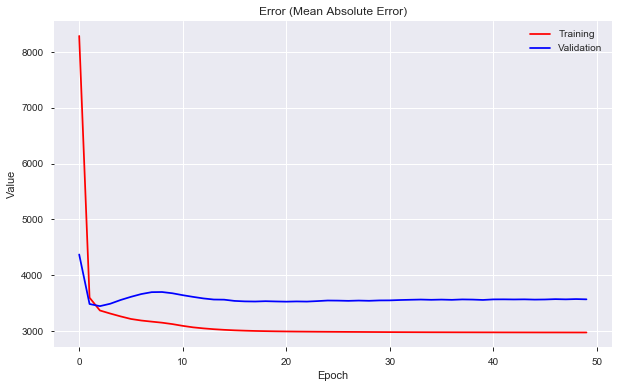

In [42]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(grid_result.best_estimator_.model.history.history["loss"], c="r")
ax.plot(grid_result.best_estimator_.model.history.history["val_loss"], c="b")
ax.set_title("Error (Mean Absolute Error)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");

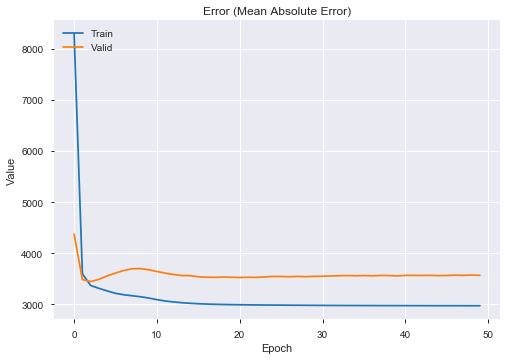

In [43]:
from matplotlib import pyplot as plt

plt.plot(grid_result.best_estimator_.model.history.history['mean_absolute_error'])
plt.plot(grid_result.best_estimator_.model.history.history['val_mean_absolute_error'])
plt.title("Error (Mean Absolute Error)")
plt.ylabel("Value")
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

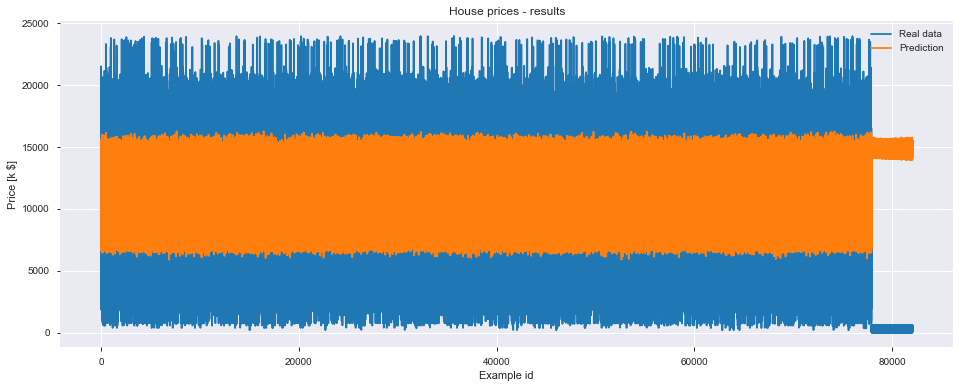

In [44]:
predictions = grid_result.predict(X_valid)

plt.figure(figsize=(16,6))
plt.plot(np.arange(0, len(Y_valid), 1), Y_valid)
plt.plot(np.arange(0, len(Y_valid), 1), predictions)
plt.title("House prices - results")
plt.ylabel("Price [k $]")
plt.xlabel("Example id")
plt.legend(["Real data", "Prediction"]);

# VI. Evaluating test set accuracy with the trained model


In [45]:
'''Before we can apply this on the test set, we
need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

mydf_test = pd.read_csv(f'{my_path}/black-friday/test.csv')
print(mydf_test.shape)
mydf_test.head(2)

(233599, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN


In [46]:
mydf_test1 = str_to_cat(mydf_test)
print(mydf_test1.shape)
mydf_test1.head(3)

(233599, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN


In [47]:
mydf_test2,my_table_1 = mydf_preprocessor(mydf_test1,null_table = None)
print(mydf_test2.shape)
mydf_test2.head(3)

(233599, 13)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Product_Category_2_na,Product_Category_3_na
0,1000004,1145,2,5,7,2,3,1,1,11.0,14.0,False,True
1,1000009,995,2,3,17,3,1,0,3,5.0,14.0,False,True
2,1000010,2673,1,4,1,2,5,1,5,14.0,14.0,False,True


In [48]:
my_table_1

{'Product_Category_2': 9.0, 'Product_Category_3': 14.0}

In [49]:
mydf_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 13 columns):
User_ID                       233599 non-null int64
Product_ID                    233599 non-null int16
Gender                        233599 non-null int8
Age                           233599 non-null int8
Occupation                    233599 non-null int64
City_Category                 233599 non-null int8
Stay_In_Current_City_Years    233599 non-null int8
Marital_Status                233599 non-null int64
Product_Category_1            233599 non-null int64
Product_Category_2            233599 non-null float64
Product_Category_3            233599 non-null float64
Product_Category_2_na         233599 non-null bool
Product_Category_3_na         233599 non-null bool
dtypes: bool(2), float64(2), int16(1), int64(4), int8(4)
memory usage: 12.5 MB


In [50]:
mydf_test_draft1= mydf_test2.drop(columns =['Product_Category_2_na','Product_Category_3_na'])

# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!

Y_t = mydf_test2["Purchase"]
X_t = mydf_test2.drop(["Purchase"],axis = 1)

print(X_t.shape,Y_t.shape)

In [51]:
X_con_t = mydf_test_draft1[['User_ID', 'Product_ID', 'Gender', 'Age','City_Category','Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Occupation',
       'Stay_In_Current_City_Years', 'Marital_Status']]
X_cat_t = mydf_test_draft1.drop(X_con_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(233599, 0) (233599, 11)


In [52]:
scaler = preprocessing.StandardScaler().fit(X_con_t)
X_con_sct = pd.DataFrame(scaler.transform(X_con))
X_con_sct.columns = ['User_ID', 'Product_ID', 'Gender', 'Age','City_Category','Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Occupation',
       'Stay_In_Current_City_Years', 'Marital_Status']
print(X_con_sc.shape)
X_con_sc.head(2)

(550068, 11)


,User_ID,Product_ID,Gender,Age,City_Category,Product_Category_1,Product_Category_2,Product_Category_3,Occupation,Stay_In_Current_City_Years,Marital_Status
0,-1.752639,-1.022993,-1.746513,-1.844248,-1.371516,-0.610809,-0.136401,0.171658,0.294864,0.109801,-0.833018
1,-1.752639,0.660469,-1.746513,-1.844248,-1.371516,-1.118912,-0.846289,0.171658,0.294864,0.109801,-0.833018


In [53]:
print(X_cat_t.shape,X_con_sct.shape)

(233599, 0) (550068, 11)


In [54]:
X_cat_t.head()

""
0
1
2
3
4


X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

In [55]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(550068, 11)


,User_ID,Product_ID,Gender,Age,City_Category,Product_Category_1,Product_Category_2,Product_Category_3,Occupation,Stay_In_Current_City_Years,Marital_Status
0,-1.754043,-0.988959,-1.74345,-1.849275,-1.373665,-0.609292,-0.137952,0.171729,0.293598,0.110432,-0.833737
1,-1.754043,0.772244,-1.74345,-1.849275,-1.373665,-1.144571,-0.843620,0.171729,0.293598,0.110432,-0.833737


In [56]:
Final_df =X_test_I.assign(Purchase =0)

In [57]:
Y_t = Final_df["Purchase"]
X_t = Final_df.drop(["Purchase"],axis = 1)

print(X_t.shape,Y_t.shape)

(550068, 11) (550068,)


# Evaluate the model

In [58]:
NN_model_final = grid_search.fit(X_train, Y_train, validation_data=(X_t,Y_t), nb_epoch=50, batch_size=1000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 2s 5us/step - loss: 9333.4779 - mean_absolute_error: 9333.4779 - val_loss: 0.4219 - val_mean_absolute_error: 0.4219
Epoch 2/50
421200/421200 [==============================] - 1s 3us/step - loss: 9333.0556 - mean_absolute_error: 9333.0556 - val_loss: 0.8439 - val_mean_absolute_error: 0.8439
Epoch 3/50
421200/421200 [==============================] - 1s 3us/step - loss: 9332.6330 - mean_absolute_error: 9332.6330 - val_loss: 1.2660 - val_mean_absolute_error: 1.2660
Epoch 4/50
421200/421200 [==============================] - 1s 3us/step - loss: 9332.2116 - mean_absolute_error: 9332.2116 - val_loss: 1.6880 - val_mean_absolute_error: 1.6880
Epoch 5/50
421200/421200 [==============================] - 1s 3us/step - loss: 9331.7892 - mean_absolute_error: 9331.7892 - val_loss: 2.1100 - val_mean_absolute_error: 2.1100
Epoch 6/50
421200/421200 [==============================] - 1s 3us/s

Epoch 47/50
421200/421200 [==============================] - 1s 3us/step - loss: 9314.0645 - mean_absolute_error: 9314.0645 - val_loss: 19.8347 - val_mean_absolute_error: 19.8347
Epoch 48/50
421200/421200 [==============================] - 1s 3us/step - loss: 9313.6423 - mean_absolute_error: 9313.6423 - val_loss: 20.2564 - val_mean_absolute_error: 20.2564
Epoch 49/50
421200/421200 [==============================] - 2s 5us/step - loss: 9313.2216 - mean_absolute_error: 9313.2216 - val_loss: 20.6782 - val_mean_absolute_error: 20.6782
Epoch 50/50
46800/46800 [==============================] - 0s 1us/step


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 2s 6us/step - loss: 9137.6166 - mean_absolute_error: 9137.6166 - val_loss: 1400.5240 - val_mean_absolute_error: 1400.5240
Epoch 2/50
421200/421200 [==============================] - 1s 3us/step - loss: 4605.2467 - mean_absolute_error: 4605.2467 - val_loss: 8661.6773 - val_mean_absolute_error: 8661.6773
Epoch 3/50
421200/421200 [==============================] - 1s 3us/step - loss: 3431.7072 - mean_absolute_error: 3431.7072 - val_loss: 8690.4136 - val_mean_absolute_error: 8690.4136
Epoch 4/50
421200/421200 [==============================] - 1s 3us/step - loss: 3365.8800 - mean_absolute_error: 3365.8800 - val_loss: 8812.9065 - val_mean_absolute_error: 8812.9065
Epoch 5/50
421200/421200 [==============================] - 1s 3us/step - loss: 3317.2666 - mean_absolute_error: 3317.2666 - val_loss: 8921.6005 - val_mean_absolute_error: 8921.6005
Epoch 6/50
421200/421200 [============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 2s 6us/step - loss: 9263.9445 - mean_absolute_error: 9263.9445 - val_loss: 441.3881 - val_mean_absolute_error: 441.3881
Epoch 2/50
421200/421200 [==============================] - 1s 3us/step - loss: 6021.6591 - mean_absolute_error: 6021.6591 - val_loss: 8233.4604 - val_mean_absolute_error: 8233.4604
Epoch 3/50
421200/421200 [==============================] - 1s 3us/step - loss: 3538.1943 - mean_absolute_error: 3538.1943 - val_loss: 8637.4308 - val_mean_absolute_error: 8637.4308
Epoch 4/50
421200/421200 [==============================] - 1s 3us/step - loss: 3412.2169 - mean_absolute_error: 3412.2169 - val_loss: 8724.3300 - val_mean_absolute_error: 8724.3300
Epoch 5/50
421200/421200 [==============================] - 1s 3us/step - loss: 3369.6218 - mean_absolute_error: 3369.6218 - val_loss: 8704.1045 - val_mean_absolute_error: 8704.1045
Epoch 6/50
421200/421200 [==============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 2s 6us/step - loss: 8918.1874 - mean_absolute_error: 8918.1874 - val_loss: 2831.1703 - val_mean_absolute_error: 2831.1703
Epoch 2/50
421200/421200 [==============================] - 1s 3us/step - loss: 4019.1881 - mean_absolute_error: 4019.1881 - val_loss: 8649.1573 - val_mean_absolute_error: 8649.1573
Epoch 3/50
421200/421200 [==============================] - 1s 3us/step - loss: 3433.5565 - mean_absolute_error: 3433.5565 - val_loss: 8665.7535 - val_mean_absolute_error: 8665.7535
Epoch 4/50
421200/421200 [==============================] - 1s 3us/step - loss: 3374.8015 - mean_absolute_error: 3374.8015 - val_loss: 8723.2441 - val_mean_absolute_error: 8723.2441
Epoch 5/50
421200/421200 [==============================] - 1s 3us/step - loss: 3335.3606 - mean_absolute_error: 3335.3606 - val_loss: 8834.9857 - val_mean_absolute_error: 8834.9857
Epoch 6/50
421200/421200 [============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 3s 6us/step - loss: 9031.3230 - mean_absolute_error: 9031.3230 - val_loss: 2146.9738 - val_mean_absolute_error: 2146.9738
Epoch 2/50
421200/421200 [==============================] - 1s 4us/step - loss: 4393.8396 - mean_absolute_error: 4393.8396 - val_loss: 8585.5719 - val_mean_absolute_error: 8585.5719
Epoch 3/50
421200/421200 [==============================] - 1s 3us/step - loss: 3501.1961 - mean_absolute_error: 3501.1961 - val_loss: 8674.7191 - val_mean_absolute_error: 8674.7191
Epoch 4/50
421200/421200 [==============================] - 1s 3us/step - loss: 3405.7514 - mean_absolute_error: 3405.7514 - val_loss: 8725.6621 - val_mean_absolute_error: 8725.6621
Epoch 5/50
421200/421200 [==============================] - 1s 3us/step - loss: 3364.1139 - mean_absolute_error: 3364.1139 - val_loss: 8701.6297 - val_mean_absolute_error: 8701.6297
Epoch 6/50
421200/421200 [============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 3s 7us/step - loss: 9092.7408 - mean_absolute_error: 9092.7408 - val_loss: 1672.0093 - val_mean_absolute_error: 1672.0093
Epoch 2/50
421200/421200 [==============================] - 1s 3us/step - loss: 4500.6568 - mean_absolute_error: 4500.6568 - val_loss: 8604.6918 - val_mean_absolute_error: 8604.6918
Epoch 3/50
421200/421200 [==============================] - 1s 4us/step - loss: 3434.0132 - mean_absolute_error: 3434.0132 - val_loss: 8690.3393 - val_mean_absolute_error: 8690.3393
Epoch 4/50
421200/421200 [==============================] - 1s 3us/step - loss: 3349.0971 - mean_absolute_error: 3349.0971 - val_loss: 8768.2392 - val_mean_absolute_error: 8768.2392
Epoch 5/50
421200/421200 [==============================] - 1s 3us/step - loss: 3298.7589 - mean_absolute_error: 3298.7589 - val_loss: 8843.4731 - val_mean_absolute_error: 8843.4731
Epoch 6/50
421200/421200 [============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 3s 6us/step - loss: 9111.9719 - mean_absolute_error: 9111.9719 - val_loss: 1501.7332 - val_mean_absolute_error: 1501.7332
Epoch 2/50
421200/421200 [==============================] - 2s 4us/step - loss: 4670.7773 - mean_absolute_error: 4670.7773 - val_loss: 8595.3380 - val_mean_absolute_error: 8595.3380
Epoch 3/50
421200/421200 [==============================] - 2s 4us/step - loss: 3486.7245 - mean_absolute_error: 3486.7245 - val_loss: 8677.6588 - val_mean_absolute_error: 8677.6588
Epoch 4/50
421200/421200 [==============================] - 1s 4us/step - loss: 3388.5982 - mean_absolute_error: 3388.5982 - val_loss: 8729.1762 - val_mean_absolute_error: 8729.1762
Epoch 5/50
421200/421200 [==============================] - 1s 4us/step - loss: 3337.6071 - mean_absolute_error: 3337.6071 - val_loss: 8767.4638 - val_mean_absolute_error: 8767.4638
Epoch 6/50
421200/421200 [============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 3s 6us/step - loss: 9163.0711 - mean_absolute_error: 9163.0711 - val_loss: 1130.1274 - val_mean_absolute_error: 1130.1274
Epoch 2/50
421200/421200 [==============================] - 2s 4us/step - loss: 4773.9405 - mean_absolute_error: 4773.9405 - val_loss: 8607.1912 - val_mean_absolute_error: 8607.1912
Epoch 3/50
421200/421200 [==============================] - 1s 4us/step - loss: 3434.1624 - mean_absolute_error: 3434.1624 - val_loss: 8687.0275 - val_mean_absolute_error: 8687.0275
Epoch 4/50
421200/421200 [==============================] - 2s 4us/step - loss: 3366.5183 - mean_absolute_error: 3366.5183 - val_loss: 8745.4626 - val_mean_absolute_error: 8745.4626
Epoch 5/50
421200/421200 [==============================] - 2s 4us/step - loss: 3324.1369 - mean_absolute_error: 3324.1369 - val_loss: 8837.3717 - val_mean_absolute_error: 8837.3717
Epoch 6/50
421200/421200 [============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 3s 7us/step - loss: 9001.5495 - mean_absolute_error: 9001.5495 - val_loss: 2268.3136 - val_mean_absolute_error: 2268.3136
Epoch 2/50
421200/421200 [==============================] - 2s 4us/step - loss: 4160.6780 - mean_absolute_error: 4160.6780 - val_loss: 8663.2537 - val_mean_absolute_error: 8663.2537
Epoch 3/50
421200/421200 [==============================] - 1s 3us/step - loss: 3390.6197 - mean_absolute_error: 3390.6197 - val_loss: 8673.7465 - val_mean_absolute_error: 8673.7465
Epoch 4/50
421200/421200 [==============================] - 2s 4us/step - loss: 3332.0158 - mean_absolute_error: 3332.0158 - val_loss: 8829.2132 - val_mean_absolute_error: 8829.2132
Epoch 5/50
421200/421200 [==============================] - 2s 4us/step - loss: 3283.5471 - mean_absolute_error: 3283.5471 - val_loss: 8915.3035 - val_mean_absolute_error: 8915.3035
Epoch 6/50
421200/421200 [============

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 421200 samples, validate on 550068 samples
Epoch 1/50
421200/421200 [==============================] - 4s 9us/step - loss: 9326.8173 - mean_absolute_error: 9326.8173 - val_loss: 0.4220 - val_mean_absolute_error: 0.4220
Epoch 2/50
421200/421200 [==============================] - 2s 5us/step - loss: 9326.3950 - mean_absolute_error: 9326.3950 - val_loss: 0.8440 - val_mean_absolute_error: 0.8440
Epoch 3/50
421200/421200 [==============================] - 2s 5us/step - loss: 9325.9724 - mean_absolute_error: 9325.9724 - val_loss: 1.2660 - val_mean_absolute_error: 1.2660
Epoch 4/50
421200/421200 [==============================] - 2s 4us/step - loss: 9325.5511 - mean_absolute_error: 9325.5511 - val_loss: 1.6880 - val_mean_absolute_error: 1.6880
Epoch 5/50
421200/421200 [==============================] - 2s 5us/step - loss: 9325.1286 - mean_absolute_error: 9325.1286 - val_loss: 2.1100 - val_mean_absolute_error: 2.1100
Epoch 6/50
421200/421200 [==============================] - 2s 5us/s

Epoch 47/50
421200/421200 [==============================] - 2s 4us/step - loss: 9307.4039 - mean_absolute_error: 9307.4039 - val_loss: 19.8347 - val_mean_absolute_error: 19.8347
Epoch 48/50
421200/421200 [==============================] - 2s 4us/step - loss: 9306.9817 - mean_absolute_error: 9306.9817 - val_loss: 20.2565 - val_mean_absolute_error: 20.2565
Epoch 49/50
421200/421200 [==============================] - 2s 5us/step - loss: 9306.5609 - mean_absolute_error: 9306.5609 - val_loss: 20.6782 - val_mean_absolute_error: 20.6782
Epoch 50/50
46800/46800 [==============================] - 0s 1us/step


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=11, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="normal")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation="relu", kernel_initializer="normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_

Train on 468000 samples, validate on 550068 samples
Epoch 1/50
468000/468000 [==============================] - 3s 7us/step - loss: 8412.2328 - mean_absolute_error: 8412.2328 - val_loss: 6076.9176 - val_mean_absolute_error: 6076.9176
Epoch 2/50
468000/468000 [==============================] - 2s 4us/step - loss: 3601.1410 - mean_absolute_error: 3601.1410 - val_loss: 8715.6781 - val_mean_absolute_error: 8715.6781
Epoch 3/50
468000/468000 [==============================] - 2s 4us/step - loss: 3393.0803 - mean_absolute_error: 3393.0803 - val_loss: 8717.1252 - val_mean_absolute_error: 8717.1252
Epoch 4/50
468000/468000 [==============================] - 2s 4us/step - loss: 3340.1506 - mean_absolute_error: 3340.1506 - val_loss: 8813.1928 - val_mean_absolute_error: 8813.1928
Epoch 5/50
468000/468000 [==============================] - 2s 4us/step - loss: 3291.2791 - mean_absolute_error: 3291.2791 - val_loss: 8915.4102 - val_mean_absolute_error: 8915.4102
Epoch 6/50
468000/468000 [============

In [69]:
print('Training loss : ' , np.mean(NN_model_final.best_estimator_.model.history.history["loss"]))
print('Testing loss : ' , np.mean(NN_model_final.best_estimator_.model.history.history["val_loss"]))

Training loss :  3149.506514224843
Testing loss :  9568.73803503772


In [59]:
from sklearn.metrics import mean_absolute_error
scores = mean_absolute_error(Y_t, NN_model_final.predict(X_t))
print (scores)

9846.191288912767


In [66]:
from sklearn.metrics import mean_absolute_error
scores = mean_absolute_error(Y_t, grid_result.predict(X_t))
print (scores)

9846.191288912767
